# Knowledge Graph Reasoning from Node2Vec to ULTRA Across Transductive and Inductive Tasks

In this notebook, we will explore graph reasoning capabilities of various graph models such as Node2Vec, Graph Convolution Network, GraphSAGE, Graph Attention Network, NodePiece, and the recent foundation model ULTRA across transductive and inductive tasks.

![lp-ultra-rest.png](../assets/img/lp-ultra-rest.png)

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from collections import defaultdict
from tqdm.notebook import tqdm

## Data Preparation

You can download the data from here: https://github.com/tsafavi/codex/tree/master/data/triples/codex-s

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        triples = [line.strip().split() for line in lines]
    return triples

def create_datasets(train_file, test_file):
    train_triples = load_data(train_file)
    test_triples = load_data(test_file)
    node2idx = defaultdict(lambda: len(node2idx))
    rel2idx = defaultdict(lambda: len(rel2idx))

    def triples_to_data(triples):
        edges = []
        indexed_triples = []
        for s, p, o in triples:
            s_idx = node2idx[s]
            p_idx = rel2idx[p]
            o_idx = node2idx[o]
            edges.append((s_idx, o_idx))
            indexed_triples.append((s_idx, p_idx, o_idx))
        src, dst = tuple(zip(*edges))
        edge_index = torch.tensor([src, dst], dtype=torch.long)
        return Data(edge_index=edge_index), indexed_triples

    train_data, train_indexed_triples = triples_to_data(train_triples)
    test_data, test_indexed_triples = triples_to_data(test_triples)

    return train_data, test_data, train_indexed_triples, test_indexed_triples

In [ ]:
train_file = osp.join('.', 'codexs_train.txt')
test_file = osp.join('.', 'codexs_test.txt')
train_data, test_data, train_indexed_triples, test_indexed_triples = create_datasets(train_file, test_file)

print(train_data)
print(test_data)

Data(edge_index=[2, 32888])
Data(edge_index=[2, 1828])


## Node2vec

We will be using PyTorch Geometric (PyG) which is a graph neural network library for pytorch. In the below code snippet, the embedding dimension is  configured to 128. The walk length, which dictates how many steps each  random walk should take, is set to 20, and we're considering a context  size of 10 nodes. Each node initiates 20 random walks. We've chosen p and q  values both as 1, keeping the walk neither too focused on its  neighborhood nor too explorative. The model parameters will be optimized  using the SparseAdam optimizer with a learning rate of 0.01.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(train_data.edge_index, embedding_dim=128,
                 walk_length=20,
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1,
                 p=1, q=1,
                 sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer_n2v = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The node2vec model is trained using positive and negative random walks. Positive samples represent actual graph connections, while negative ones are non-connections. Over 50 epochs, the model optimizes its embeddings to differentiate between these true and false relationships. After training, embeddings for all nodes are computed.

In [ ]:
def train_node2vec():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer_n2v.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer_n2v.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 50):
    loss = train_node2vec()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 5.6680
Epoch: 02, Loss: 4.7918
Epoch: 03, Loss: 4.0306
Epoch: 04, Loss: 3.3688
Epoch: 05, Loss: 2.8174
Epoch: 06, Loss: 2.3759
Epoch: 07, Loss: 2.0316
Epoch: 08, Loss: 1.7602
Epoch: 09, Loss: 1.5437
Epoch: 10, Loss: 1.3729
Epoch: 11, Loss: 1.2374
Epoch: 12, Loss: 1.1322
Epoch: 13, Loss: 1.0479
Epoch: 14, Loss: 0.9823
Epoch: 15, Loss: 0.9328
Epoch: 16, Loss: 0.8950
Epoch: 17, Loss: 0.8652
Epoch: 18, Loss: 0.8412
Epoch: 19, Loss: 0.8241
Epoch: 20, Loss: 0.8100
Epoch: 21, Loss: 0.7986
Epoch: 22, Loss: 0.7898
Epoch: 23, Loss: 0.7828
Epoch: 24, Loss: 0.7775
Epoch: 25, Loss: 0.7719
Epoch: 26, Loss: 0.7676
Epoch: 27, Loss: 0.7646
Epoch: 28, Loss: 0.7617
Epoch: 29, Loss: 0.7591
Epoch: 30, Loss: 0.7571
Epoch: 31, Loss: 0.7560
Epoch: 32, Loss: 0.7538
Epoch: 33, Loss: 0.7527
Epoch: 34, Loss: 0.7506
Epoch: 35, Loss: 0.7499
Epoch: 36, Loss: 0.7483
Epoch: 37, Loss: 0.7478
Epoch: 38, Loss: 0.7470
Epoch: 39, Loss: 0.7461
Epoch: 40, Loss: 0.7456
Epoch: 41, Loss: 0.7452
Epoch: 42, Loss:

In [ ]:
model.eval()
z = model()

Now, we define a multilayer perceptron model using PyTorch, which consists of six linear layers, each followed by batch normalization, ReLU activation, and dropout for regularization. The model takes in concatenated embeddings from Node2Vec of pairs of entities (heads and tails) and learns to predict the relations between them. The MLP is trained using the Adam optimizer and cross-entropy loss over 50 epochs, aiming to minimize the difference between its predicted relations and the true relations from the training data. Also, this code remains the same for most of the other methods after node2vec. Basically, we use these graph neural network methods for generating node embeddings and use an MLP for a downstream task.

In [ ]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = torch.nn.Linear(in_dim, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64)

        self.lin2 = torch.nn.Linear(64, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)

        self.lin3 = torch.nn.Linear(128, 256)
        self.batch_norm3 = torch.nn.BatchNorm1d(256)

        self.lin4 = torch.nn.Linear(256, 128)
        self.batch_norm4 = torch.nn.BatchNorm1d(128)

        self.lin5 = torch.nn.Linear(128, 64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.lin6 = torch.nn.Linear(64, out_dim)

        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.lin1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin6(x)

        return torch.sigmoid(x)

z = model().detach()
mlp_model = MLP(in_dim=2*z.size(1), out_dim=z.size(0)).to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
train_triples_tensor = torch.tensor(train_indexed_triples, dtype=torch.long).to(device)
X_train = torch.cat([z[train_triples_tensor[:, 0]], z[train_triples_tensor[:, 2]]], dim=1)
y_train = train_triples_tensor[:, 1]

def train_mlp():
    mlp_model.train()
    optimizer.zero_grad()
    out = mlp_model(X_train)
    loss = F.cross_entropy(out, y_train)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 50):
    loss = train_mlp()
    print(f'Epoch: {epoch:02d}, MLP Loss: {loss:.4f}')

Epoch: 01, MLP Loss: 7.6552
Epoch: 02, MLP Loss: 7.5243
Epoch: 03, MLP Loss: 7.3744
Epoch: 04, MLP Loss: 7.2190
Epoch: 05, MLP Loss: 7.0991
Epoch: 06, MLP Loss: 6.9955
Epoch: 07, MLP Loss: 6.9101
Epoch: 08, MLP Loss: 6.8410
Epoch: 09, MLP Loss: 6.7888
Epoch: 10, MLP Loss: 6.7503
Epoch: 11, MLP Loss: 6.7221
Epoch: 12, MLP Loss: 6.7015
Epoch: 13, MLP Loss: 6.6867
Epoch: 14, MLP Loss: 6.6762
Epoch: 15, MLP Loss: 6.6686
Epoch: 16, MLP Loss: 6.6628
Epoch: 17, MLP Loss: 6.6586
Epoch: 18, MLP Loss: 6.6556
Epoch: 19, MLP Loss: 6.6534
Epoch: 20, MLP Loss: 6.6515
Epoch: 21, MLP Loss: 6.6500
Epoch: 22, MLP Loss: 6.6489
Epoch: 23, MLP Loss: 6.6479
Epoch: 24, MLP Loss: 6.6473
Epoch: 25, MLP Loss: 6.6467
Epoch: 26, MLP Loss: 6.6462
Epoch: 27, MLP Loss: 6.6458
Epoch: 28, MLP Loss: 6.6454
Epoch: 29, MLP Loss: 6.6451
Epoch: 30, MLP Loss: 6.6449
Epoch: 31, MLP Loss: 6.6447
Epoch: 32, MLP Loss: 6.6445
Epoch: 33, MLP Loss: 6.6443
Epoch: 34, MLP Loss: 6.6442
Epoch: 35, MLP Loss: 6.6441
Epoch: 36, MLP Loss:

Given test triples, we fix the head and relation, the code evaluates the model's ability to predict the tail, and vice-versa. The model ranks its predictions for the correct entities or relations against all possible alternatives. The function returns two common evaluation metrics for link prediction tasks: the Mean Reciprocal Rank (MRR) and the proportion of correct predictions within the top 100 ranks (Hits@100).

In [ ]:
def evaluate_mlp(test_triples_tensor):
    mlp_model.eval()
    with torch.no_grad():
        ranks = []
        for triple in test_triples_tensor:
            input_data = torch.cat([z, z[triple[2]].view(1, -1).repeat(z.size(0), 1)], dim=1)
            scores = mlp_model(input_data)
            rank = (scores[:, triple[1]] < scores[triple[0], triple[1]]).sum().item() + 1
            ranks.append(rank)
            input_data = torch.cat([z[triple[0]].view(1, -1).repeat(z.size(0), 1), z], dim=1)
            scores = mlp_model(input_data)
            rank = (scores[:, triple[2]] < scores[triple[0], triple[2]]).sum().item() + 1
            ranks.append(rank)
        ranks = torch.tensor(ranks)
        mrr = (1 / ranks.float()).mean().item()
        hits_at_100 = (ranks <= 100).float().mean().item()
    return mrr, hits_at_100

In [ ]:
test_triples_tensor = torch.tensor(test_indexed_triples, dtype=torch.long).to(device)
mrr, hits_at_100 = evaluate_mlp(test_triples_tensor)

print(f'MRR: {mrr:.4f}, Hits@100: {hits_at_100:.4f}')

MRR: 0.0037, Hits@100: 0.0670


## Graph Convolutional Network

A Graph Convolutional Network (GCN) introduced in Semi-Supervised Classification with Graph Convolutional Networks  is a neural network architecture designed for learning on graph-structured data. GCNs propagate information between neighboring nodes in a graph, using layers of graph convolutions. In each layer, a node aggregates features from its neighbors and updates its own feature. This allows the network to capture local graph structures and hierarchies in the data, making GCNs effective for tasks like node classification and graph classification.

For GCN, we employ a different strategy to generate negative samples compared to node2vec. The generate_negative_samples function produces negative edges by randomly sampling pairs of nodes until the desired number of negative samples is reached. These samples are ensured not to exist in the actual graph edges or be self-loops. In contrast to node2vec, where negative sampling is implicitly handled during random walks, the GCN requires an explicit generation of negative edges for training. This distinction arises due to the differing learning paradigms and objectives between GCN and node2vec.

In [ ]:
def generate_negative_samples(edge_index, num_nodes, num_neg_samples):
    neg_samples = []
    while len(neg_samples) < num_neg_samples:
        src = random.randint(0, num_nodes-1)
        dst = random.randint(0, num_nodes-1)
        if (src, dst) not in edge_index.t().tolist() and (src != dst):
            neg_samples.append((src, dst))
    return torch.tensor(neg_samples, dtype=torch.long).t()

num_neg_samples = int(0.1 * train_data.edge_index.size(1))
num_nodes = int(train_data.edge_index.max()) + 1
negative_edge_index = generate_negative_samples(train_data.edge_index, num_nodes, num_neg_samples)

Here, is the GCN class which is used to train the embeddings of graph network.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, embed_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embed_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def compute_scores(node_emb1, node_emb2):
    scores = (node_emb1 * node_emb2).sum(dim=-1)
    return scores

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
negative_edge_index = negative_edge_index.to(device)

num_nodes = int(train_data.edge_index.max()) + 1
train_data.x = torch.eye(num_nodes).to(device)
num_features = num_nodes
hidden_channels = 32
embed_dim = 64

model = GCN(num_features, hidden_channels, embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    node_embeddings = model(train_data.x, train_data.edge_index)
    pos_scores = compute_scores(node_embeddings[train_data.edge_index[0]],
                                node_embeddings[train_data.edge_index[1]])
    neg_scores = compute_scores(node_embeddings[negative_edge_index[0]],
                                node_embeddings[negative_edge_index[1]])
    total_scores = torch.cat([pos_scores.view(-1), neg_scores.view(-1)])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).to(device)
    loss = F.binary_cross_entropy_with_logits(total_scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(50):
    loss = train()
    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 000, Loss: 0.6714
Epoch: 001, Loss: 0.5166
Epoch: 002, Loss: 0.3265
Epoch: 003, Loss: 0.3191
Epoch: 004, Loss: 0.3731
Epoch: 005, Loss: 0.3422
Epoch: 006, Loss: 0.2858
Epoch: 007, Loss: 0.2513
Epoch: 008, Loss: 0.2489
Epoch: 009, Loss: 0.2608
Epoch: 010, Loss: 0.2660
Epoch: 011, Loss: 0.2577
Epoch: 012, Loss: 0.2422
Epoch: 013, Loss: 0.2299
Epoch: 014, Loss: 0.2267
Epoch: 015, Loss: 0.2311
Epoch: 016, Loss: 0.2370
Epoch: 017, Loss: 0.2393
Epoch: 018, Loss: 0.2367
Epoch: 019, Loss: 0.2313
Epoch: 020, Loss: 0.2264
Epoch: 021, Loss: 0.2244
Epoch: 022, Loss: 0.2254
Epoch: 023, Loss: 0.2277
Epoch: 024, Loss: 0.2291
Epoch: 025, Loss: 0.2285
Epoch: 026, Loss: 0.2262
Epoch: 027, Loss: 0.2235
Epoch: 028, Loss: 0.2218
Epoch: 029, Loss: 0.2215
Epoch: 030, Loss: 0.2221
Epoch: 031, Loss: 0.2228
Epoch: 032, Loss: 0.2227
Epoch: 033, Loss: 0.2218
Epoch: 034, Loss: 0.2205
Epoch: 035, Loss: 0.2193
Epoch: 036, Loss: 0.2189
Epoch: 037, Loss: 0.2190
Epoch: 038, Loss: 0.2194
Epoch: 039, Loss: 0.2195


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = torch.nn.Linear(in_dim, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64)

        self.lin2 = torch.nn.Linear(64, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)

        self.lin3 = torch.nn.Linear(128, 256)
        self.batch_norm3 = torch.nn.BatchNorm1d(256)

        self.lin4 = torch.nn.Linear(256, 128)
        self.batch_norm4 = torch.nn.BatchNorm1d(128)

        self.lin5 = torch.nn.Linear(128, 64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.lin6 = torch.nn.Linear(64, out_dim)

        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.lin1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin6(x)

        return torch.sigmoid(x)

node_embeddings = model(train_data.x, train_data.edge_index).detach()

X_train_pos = torch.cat([node_embeddings[train_data.edge_index[0]],
                         node_embeddings[train_data.edge_index[1]]], dim=1)
y_train_pos = torch.ones(train_data.edge_index.size(1), 1).to(device)

X_train_neg = torch.cat([node_embeddings[negative_edge_index[0]],
                         node_embeddings[negative_edge_index[1]]], dim=1)
y_train_neg = torch.zeros(negative_edge_index.size(1), 1).to(device)

X_train = torch.cat([X_train_pos, X_train_neg], dim=0)
y_train = torch.cat([y_train_pos, y_train_neg], dim=0)

In [ ]:
mlp_model = MLP(in_dim=2*embed_dim, out_dim=1).to(device)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

def train_mlp():
    mlp_model.train()
    mlp_optimizer.zero_grad()
    out = mlp_model(X_train)
    loss = F.binary_cross_entropy(out, y_train)
    loss.backward()
    mlp_optimizer.step()
    return loss.item()

for epoch in range(50):
    mlp_loss = train_mlp()
    print('Epoch: {:03d}, MLP Loss: {:.4f}'.format(epoch, mlp_loss))

Epoch: 000, MLP Loss: 0.6012
Epoch: 001, MLP Loss: 0.5017
Epoch: 002, MLP Loss: 0.4223
Epoch: 003, MLP Loss: 0.3450
Epoch: 004, MLP Loss: 0.3003
Epoch: 005, MLP Loss: 0.2709
Epoch: 006, MLP Loss: 0.2495
Epoch: 007, MLP Loss: 0.2319
Epoch: 008, MLP Loss: 0.2236
Epoch: 009, MLP Loss: 0.2142
Epoch: 010, MLP Loss: 0.2098
Epoch: 011, MLP Loss: 0.2067
Epoch: 012, MLP Loss: 0.2021
Epoch: 013, MLP Loss: 0.2022
Epoch: 014, MLP Loss: 0.2007
Epoch: 015, MLP Loss: 0.1971
Epoch: 016, MLP Loss: 0.1934
Epoch: 017, MLP Loss: 0.1936
Epoch: 018, MLP Loss: 0.1922
Epoch: 019, MLP Loss: 0.1885
Epoch: 020, MLP Loss: 0.1875
Epoch: 021, MLP Loss: 0.1873
Epoch: 022, MLP Loss: 0.1852
Epoch: 023, MLP Loss: 0.1844
Epoch: 024, MLP Loss: 0.1824
Epoch: 025, MLP Loss: 0.1816
Epoch: 026, MLP Loss: 0.1802
Epoch: 027, MLP Loss: 0.1787
Epoch: 028, MLP Loss: 0.1779
Epoch: 029, MLP Loss: 0.1765
Epoch: 030, MLP Loss: 0.1780
Epoch: 031, MLP Loss: 0.1737
Epoch: 032, MLP Loss: 0.1736
Epoch: 033, MLP Loss: 0.1745
Epoch: 034, ML

In [ ]:
def evaluate_gcn(test_triples_tensor, node_embeddings):
    mlp_model.eval()
    with torch.no_grad():
        ranks = []
        for triple in test_triples_tensor:
            scores_head = (node_embeddings * node_embeddings[triple[2]]).sum(dim=1)
            scores_tail = (node_embeddings[triple[0]] * node_embeddings).sum(dim=1)
            rank_head = (scores_head < scores_head[triple[0]]).sum().item() + 1
            ranks.append(rank_head)
            rank_tail = (scores_tail < scores_tail[triple[2]]).sum().item() + 1
            ranks.append(rank_tail)
        ranks = torch.tensor(ranks)
        mrr = (1 / ranks.float()).mean().item()
        hits_at_100 = (ranks <= 100).float().mean().item()
    return mrr, hits_at_100

node_embeddings = model(train_data.x, train_data.edge_index).detach()

# Evaluation
test_triples_tensor = torch.tensor(test_indexed_triples, dtype=torch.long).to(device)
mrr, hits_at_100 = evaluate_gcn(test_triples_tensor, node_embeddings)

print(f'MRR: {mrr:.4f}, Hits@100: {hits_at_100:.4f}')

MRR: 0.0137, Hits@100: 0.0243


## GraphSAGE

GraphSAGE introduced in Inductive Representation Learning on Large Graphs  is another graph neural network architecture designed to inductively learn embeddings for nodes in a graph. The key idea behind GraphSAGE is to generate embeddings by sampling and aggregating features from a node's neighbors. Instead of aggregating features from all neighbors, GraphSAGE samples a fixed-size set of neighbors, which allows it to handle graphs of varying sizes and degrees. After sampling, GraphSAGE aggregates the features of the sampled neighbors using various methods like mean, LSTM, or pooling. This aggregated information is then combined with the target node's features to generate an updated embedding.

In [ ]:
def generate_negative_samples(edge_index, num_nodes, num_neg_samples):
    neg_samples = []
    while len(neg_samples) < num_neg_samples:
        src = random.randint(0, num_nodes-1)
        dst = random.randint(0, num_nodes-1)
        if (src, dst) not in edge_index.t().tolist() and (src != dst):
            neg_samples.append((src, dst))
    return torch.tensor(neg_samples, dtype=torch.long).t()

num_neg_samples = int(0.1 * train_data.edge_index.size(1))
num_nodes = int(train_data.edge_index.max()) + 1
negative_edge_index = generate_negative_samples(train_data.edge_index, num_nodes, num_neg_samples)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, embed_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, embed_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def compute_scores(node_emb1, node_emb2):
    scores = (node_emb1 * node_emb2).sum(dim=-1)
    return scores

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
negative_edge_index = negative_edge_index.to(device)

num_nodes = int(train_data.edge_index.max()) + 1
train_data.x = torch.eye(num_nodes).to(device)
num_features = num_nodes
hidden_channels = 128
embed_dim = 64

model = GraphSAGE(num_features, hidden_channels, embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    node_embeddings = model(train_data.x, train_data.edge_index)
    pos_scores = compute_scores(node_embeddings[train_data.edge_index[0]],
                                node_embeddings[train_data.edge_index[1]])
    neg_scores = compute_scores(node_embeddings[negative_edge_index[0]],
                                node_embeddings[negative_edge_index[1]])
    total_scores = torch.cat([pos_scores.view(-1), neg_scores.view(-1)])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).to(device)
    loss = F.binary_cross_entropy_with_logits(total_scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(50):
    loss = train()
    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 000, Loss: 0.6199
Epoch: 001, Loss: 0.4701
Epoch: 002, Loss: 0.2861
Epoch: 003, Loss: 0.3981
Epoch: 004, Loss: 0.3356
Epoch: 005, Loss: 0.2580
Epoch: 006, Loss: 0.2503
Epoch: 007, Loss: 0.2705
Epoch: 008, Loss: 0.2701
Epoch: 009, Loss: 0.2493
Epoch: 010, Loss: 0.2271
Epoch: 011, Loss: 0.2187
Epoch: 012, Loss: 0.2235
Epoch: 013, Loss: 0.2300
Epoch: 014, Loss: 0.2300
Epoch: 015, Loss: 0.2238
Epoch: 016, Loss: 0.2156
Epoch: 017, Loss: 0.2097
Epoch: 018, Loss: 0.2077
Epoch: 019, Loss: 0.2087
Epoch: 020, Loss: 0.2104
Epoch: 021, Loss: 0.2107
Epoch: 022, Loss: 0.2091
Epoch: 023, Loss: 0.2062
Epoch: 024, Loss: 0.2035
Epoch: 025, Loss: 0.2018
Epoch: 026, Loss: 0.2015
Epoch: 027, Loss: 0.2018
Epoch: 028, Loss: 0.2021
Epoch: 029, Loss: 0.2018
Epoch: 030, Loss: 0.2007
Epoch: 031, Loss: 0.1992
Epoch: 032, Loss: 0.1977
Epoch: 033, Loss: 0.1967
Epoch: 034, Loss: 0.1963
Epoch: 035, Loss: 0.1962
Epoch: 036, Loss: 0.1959
Epoch: 037, Loss: 0.1950
Epoch: 038, Loss: 0.1937
Epoch: 039, Loss: 0.1923


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = torch.nn.Linear(in_dim, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64)

        self.lin2 = torch.nn.Linear(64, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)

        self.lin3 = torch.nn.Linear(128, 256)
        self.batch_norm3 = torch.nn.BatchNorm1d(256)

        self.lin4 = torch.nn.Linear(256, 128)
        self.batch_norm4 = torch.nn.BatchNorm1d(128)

        self.lin5 = torch.nn.Linear(128, 64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.lin6 = torch.nn.Linear(64, out_dim)

        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.lin1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin6(x)

        return torch.sigmoid(x)

node_embeddings = model(train_data.x, train_data.edge_index).detach()

X_train_pos = torch.cat([node_embeddings[train_data.edge_index[0]],
                         node_embeddings[train_data.edge_index[1]]], dim=1)
y_train_pos = torch.ones(train_data.edge_index.size(1), 1).to(device)

X_train_neg = torch.cat([node_embeddings[negative_edge_index[0]],
                         node_embeddings[negative_edge_index[1]]], dim=1)
y_train_neg = torch.zeros(negative_edge_index.size(1), 1).to(device)

X_train = torch.cat([X_train_pos, X_train_neg], dim=0)
y_train = torch.cat([y_train_pos, y_train_neg], dim=0)

In [ ]:
mlp_model = MLP(in_dim=2*embed_dim, out_dim=1).to(device)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

def train_mlp():
    mlp_model.train()
    mlp_optimizer.zero_grad()
    out = mlp_model(X_train)
    loss = F.binary_cross_entropy(out, y_train)
    loss.backward()
    mlp_optimizer.step()
    return loss.item()

for epoch in range(50):
    mlp_loss = train_mlp()
    print('Epoch: {:03d}, MLP Loss: {:.4f}'.format(epoch, mlp_loss))

Epoch: 000, MLP Loss: 0.5960
Epoch: 001, MLP Loss: 0.5279
Epoch: 002, MLP Loss: 0.4382
Epoch: 003, MLP Loss: 0.3548
Epoch: 004, MLP Loss: 0.3049
Epoch: 005, MLP Loss: 0.2743
Epoch: 006, MLP Loss: 0.2527
Epoch: 007, MLP Loss: 0.2356
Epoch: 008, MLP Loss: 0.2255
Epoch: 009, MLP Loss: 0.2168
Epoch: 010, MLP Loss: 0.2105
Epoch: 011, MLP Loss: 0.2066
Epoch: 012, MLP Loss: 0.2046
Epoch: 013, MLP Loss: 0.2025
Epoch: 014, MLP Loss: 0.2014
Epoch: 015, MLP Loss: 0.2001
Epoch: 016, MLP Loss: 0.1980
Epoch: 017, MLP Loss: 0.1953
Epoch: 018, MLP Loss: 0.1963
Epoch: 019, MLP Loss: 0.1948
Epoch: 020, MLP Loss: 0.1925
Epoch: 021, MLP Loss: 0.1948
Epoch: 022, MLP Loss: 0.1907
Epoch: 023, MLP Loss: 0.1919
Epoch: 024, MLP Loss: 0.1885
Epoch: 025, MLP Loss: 0.1867
Epoch: 026, MLP Loss: 0.1855
Epoch: 027, MLP Loss: 0.1872
Epoch: 028, MLP Loss: 0.1863
Epoch: 029, MLP Loss: 0.1864
Epoch: 030, MLP Loss: 0.1850
Epoch: 031, MLP Loss: 0.1850
Epoch: 032, MLP Loss: 0.1825
Epoch: 033, MLP Loss: 0.1814
Epoch: 034, ML

In [ ]:
def evaluate_graphsage(test_triples_tensor, node_embeddings):
    mlp_model.eval()
    with torch.no_grad():
        ranks = []
        for triple in test_triples_tensor:
            scores_head = (node_embeddings * node_embeddings[triple[2]]).sum(dim=1)
            scores_tail = (node_embeddings[triple[0]] * node_embeddings).sum(dim=1)
            rank_head = (scores_head < scores_head[triple[0]]).sum().item() + 1
            ranks.append(rank_head)
            rank_tail = (scores_tail < scores_tail[triple[2]]).sum().item() + 1
            ranks.append(rank_tail)
        ranks = torch.tensor(ranks)
        mrr = (1 / ranks.float()).mean().item()
        hits_at_100 = (ranks <= 100).float().mean().item()
    return mrr, hits_at_100

node_embeddings = model(train_data.x, train_data.edge_index).detach()

# Evaluation
test_triples_tensor = torch.tensor(test_indexed_triples, dtype=torch.long).to(device)
mrr, hits_at_100 = evaluate_graphsage(test_triples_tensor, node_embeddings)

print(f'MRR: {mrr:.4f}, Hits@100: {hits_at_100:.4f}')

MRR: 0.0016, Hits@100: 0.0115


## Graph Attention Network

Graph Attention Networks (GAT) introduced in Graph Attention Networks introduces an attention mechanism that computes weights for the nodes in a neighborhood, enabling the model to focus on the most relevant parts of the input graph during aggregation. This attention mechanism allows nodes to assign different importances to their neighbors. Instead of treating neighboring nodes equally (like in GCN), GAT uses shared self-attention layers to weigh the importance of each neighbor node. This weight is computed based on the similarity of the source node's features to its neighboring nodes' features.
Unlike GCN, and GraphSAGE, here in GAT model we add additional complexity for learning and experimentation purposes. Here, we add multi attention heads, batch normalization, and dropout layers.

In [ ]:
def generate_negative_samples(edge_index, num_nodes, num_neg_samples):
    neg_samples = []
    while len(neg_samples) < num_neg_samples:
        src = random.randint(0, num_nodes-1)
        dst = random.randint(0, num_nodes-1)
        if (src, dst) not in edge_index.t().tolist() and (src != dst):
            neg_samples.append((src, dst))
    return torch.tensor(neg_samples, dtype=torch.long).t()

num_neg_samples = int(0.1 * train_data.edge_index.size(1))
num_nodes = int(train_data.edge_index.max()) + 1
negative_edge_index = generate_negative_samples(train_data.edge_index, num_nodes, num_neg_samples)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm

class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, embed_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, concat=True, dropout=0.6)
        self.bn1 = BatchNorm(hidden_channels * 4)

        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, concat=True, dropout=0.6)
        self.bn2 = BatchNorm(hidden_channels * 4)

        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=4, concat=True, dropout=0.6)
        self.bn3 = BatchNorm(hidden_channels * 4)

        self.conv4 = GATConv(hidden_channels * 4, embed_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv4(x, edge_index)
        return x

def compute_scores(node_emb1, node_emb2):
    scores = (node_emb1 * node_emb2).sum(dim=-1)
    return scores

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
negative_edge_index = negative_edge_index.to(device)

num_nodes = int(train_data.edge_index.max()) + 1
train_data.x = torch.eye(num_nodes).to(device)
num_features = num_nodes
hidden_channels = 32
embed_dim = 64

model = GAT(num_features, hidden_channels, embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    node_embeddings = model(train_data.x, train_data.edge_index)
    pos_scores = compute_scores(node_embeddings[train_data.edge_index[0]],
                                node_embeddings[train_data.edge_index[1]])
    neg_scores = compute_scores(node_embeddings[negative_edge_index[0]],
                                node_embeddings[negative_edge_index[1]])
    total_scores = torch.cat([pos_scores.view(-1), neg_scores.view(-1)])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).to(device)
    loss = F.binary_cross_entropy_with_logits(total_scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(50):
    loss = train()
    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 000, Loss: 3.4301
Epoch: 001, Loss: 1.3863
Epoch: 002, Loss: 1.4905
Epoch: 003, Loss: 1.2164
Epoch: 004, Loss: 0.9060
Epoch: 005, Loss: 0.6767
Epoch: 006, Loss: 0.7397
Epoch: 007, Loss: 0.7324
Epoch: 008, Loss: 0.7329
Epoch: 009, Loss: 0.7325
Epoch: 010, Loss: 0.6709
Epoch: 011, Loss: 0.7141
Epoch: 012, Loss: 0.8091
Epoch: 013, Loss: 0.6990
Epoch: 014, Loss: 0.7151
Epoch: 015, Loss: 0.5908
Epoch: 016, Loss: 0.5845
Epoch: 017, Loss: 0.4806
Epoch: 018, Loss: 0.5416
Epoch: 019, Loss: 0.4983
Epoch: 020, Loss: 0.5091
Epoch: 021, Loss: 0.4579
Epoch: 022, Loss: 0.4296
Epoch: 023, Loss: 0.4289
Epoch: 024, Loss: 0.4760
Epoch: 025, Loss: 0.3998
Epoch: 026, Loss: 0.4189
Epoch: 027, Loss: 0.3682
Epoch: 028, Loss: 0.3887
Epoch: 029, Loss: 0.4259
Epoch: 030, Loss: 0.3626
Epoch: 031, Loss: 0.3529
Epoch: 032, Loss: 0.3800
Epoch: 033, Loss: 0.3883
Epoch: 034, Loss: 0.3363
Epoch: 035, Loss: 0.3476
Epoch: 036, Loss: 0.3295
Epoch: 037, Loss: 0.3556
Epoch: 038, Loss: 0.3478
Epoch: 039, Loss: 0.3299


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = torch.nn.Linear(in_dim, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64)

        self.lin2 = torch.nn.Linear(64, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)

        self.lin3 = torch.nn.Linear(128, 256)
        self.batch_norm3 = torch.nn.BatchNorm1d(256)

        self.lin4 = torch.nn.Linear(256, 128)
        self.batch_norm4 = torch.nn.BatchNorm1d(128)

        self.lin5 = torch.nn.Linear(128, 64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.lin6 = torch.nn.Linear(64, out_dim)

        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.lin1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.lin6(x)

        return torch.sigmoid(x)

node_embeddings = model(train_data.x, train_data.edge_index).detach()

X_train_pos = torch.cat([node_embeddings[train_data.edge_index[0]],
                         node_embeddings[train_data.edge_index[1]]], dim=1)
y_train_pos = torch.ones(train_data.edge_index.size(1), 1).to(device)

X_train_neg = torch.cat([node_embeddings[negative_edge_index[0]],
                         node_embeddings[negative_edge_index[1]]], dim=1)
y_train_neg = torch.zeros(negative_edge_index.size(1), 1).to(device)

X_train = torch.cat([X_train_pos, X_train_neg], dim=0)
y_train = torch.cat([y_train_pos, y_train_neg], dim=0)

In [ ]:
mlp_model = MLP(in_dim=2*embed_dim, out_dim=1).to(device)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.05)

def train_mlp():
    mlp_model.train()
    mlp_optimizer.zero_grad()
    out = mlp_model(X_train)
    loss = F.binary_cross_entropy(out, y_train)
    loss.backward()
    mlp_optimizer.step()
    return loss.item()

for epoch in range(50):
    mlp_loss = train_mlp()
    print('Epoch: {:03d}, MLP Loss: {:.4f}'.format(epoch, mlp_loss))

Epoch: 000, MLP Loss: 0.6301
Epoch: 001, MLP Loss: 0.4546
Epoch: 002, MLP Loss: 0.3408
Epoch: 003, MLP Loss: 0.3760
Epoch: 004, MLP Loss: 0.3865
Epoch: 005, MLP Loss: 0.3781
Epoch: 006, MLP Loss: 0.3536
Epoch: 007, MLP Loss: 0.3400
Epoch: 008, MLP Loss: 0.3232
Epoch: 009, MLP Loss: 0.3184
Epoch: 010, MLP Loss: 0.3080
Epoch: 011, MLP Loss: 0.3053
Epoch: 012, MLP Loss: 0.2803
Epoch: 013, MLP Loss: 0.2703
Epoch: 014, MLP Loss: 0.2775
Epoch: 015, MLP Loss: 0.2674
Epoch: 016, MLP Loss: 0.2542
Epoch: 017, MLP Loss: 0.2494
Epoch: 018, MLP Loss: 0.2474
Epoch: 019, MLP Loss: 0.2476
Epoch: 020, MLP Loss: 0.2391
Epoch: 021, MLP Loss: 0.2301
Epoch: 022, MLP Loss: 0.2351
Epoch: 023, MLP Loss: 0.2273
Epoch: 024, MLP Loss: 0.2262
Epoch: 025, MLP Loss: 0.2239
Epoch: 026, MLP Loss: 0.2210
Epoch: 027, MLP Loss: 0.2234
Epoch: 028, MLP Loss: 0.2165
Epoch: 029, MLP Loss: 0.2133
Epoch: 030, MLP Loss: 0.2061
Epoch: 031, MLP Loss: 0.2149
Epoch: 032, MLP Loss: 0.2089
Epoch: 033, MLP Loss: 0.1997
Epoch: 034, ML

In [ ]:
def evaluate_gat(test_triples_tensor, node_embeddings):
    mlp_model.eval()
    with torch.no_grad():
        ranks = []
        for triple in test_triples_tensor:
            scores_head = (node_embeddings * node_embeddings[triple[2]]).sum(dim=1)
            scores_tail = (node_embeddings[triple[0]] * node_embeddings).sum(dim=1)
            rank_head = (scores_head < scores_head[triple[0]]).sum().item() + 1
            ranks.append(rank_head)
            rank_tail = (scores_tail < scores_tail[triple[2]]).sum().item() + 1
            ranks.append(rank_tail)
        ranks = torch.tensor(ranks)
        mrr = (1 / ranks.float()).mean().item()
        hits_at_100 = (ranks <= 100).float().mean().item()
    return mrr, hits_at_100

node_embeddings = model(train_data.x, train_data.edge_index).detach()

# Evaluation
test_triples_tensor = torch.tensor(test_indexed_triples, dtype=torch.long).to(device)
mrr, hits_at_100 = evaluate_gat(test_triples_tensor, node_embeddings)

print(f'MRR: {mrr:.4f}, Hits@100: {hits_at_100:.4f}')

MRR: 0.0033, Hits@100: 0.0271


## NodePiece Transductive

We use pykeen which is Python library for learning and evaluating knowledge graph embeddings. We first initialize the CoDExSmall dataset used for this Transductive setting similar to previous models. Unlike the InductiveNodePieceGNN model which is applied for the Inductive setting not only has the nodepiece model for generating graph features, but also has the GNN head for training and inference for a downstream task. Hence, for the transductive setting, I had to pass the features from the nodepiece model to the GCN model separately.

In [30]:
! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git

In [ ]:
import os
import torch
import pykeen
import torch.optim as optim
from pykeen.datasets import CoDExSmall
from pykeen.pipeline import pipeline
from pykeen import predict
from pykeen.models import CompGCN
from pykeen.training import SLCWATrainingLoop
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = CoDExSmall(create_inverse_triples=True)

In [ ]:
result = pipeline(
    dataset=dataset,
    model="NodePiece",
    training_kwargs=dict(
        num_epochs=200,
        use_tqdm_batch=False,
    ),
    random_seed=1235,
)

INFO:pykeen.pipeline.api:Using device: None


sampling:   0%|          | 0.00/2.03k [00:00<?, ?it/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.53s seconds


In [ ]:
save_location = "results"
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=2034, num_relations=84, create_inverse_triples=True, num_triples=32888, path="/root/.data/pykeen/datasets/codexsmall/train.txt") to file:///content/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results


['training_triples', 'metadata.json', 'trained_model.pkl', 'results.json']

In [ ]:
model = result.model
model

NodePiece(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): DistMultInteraction()
  (entity_representations): ModuleList(
    (0): NodePieceRepresentation(
      (base): ModuleList(
        (0): TokenizationRepresentation(
          (vocabulary): Embedding(
            (_embeddings): Embedding(85, 64)
          )
        )
      )
      (combination): ConcatAggregationCombination()
    )
  )
  (relation_representations): ModuleList(
    (0): SubsetRepresentation(
      (base): Embedding(
        (_embeddings): Embedding(85, 64)
      )
    )
  )
  (weight_regularizers): ModuleList()
)

In [ ]:
tf = result.training
tf.num_entities, tf.num_relations, tf.num_triples

(2034, 84, 32888)

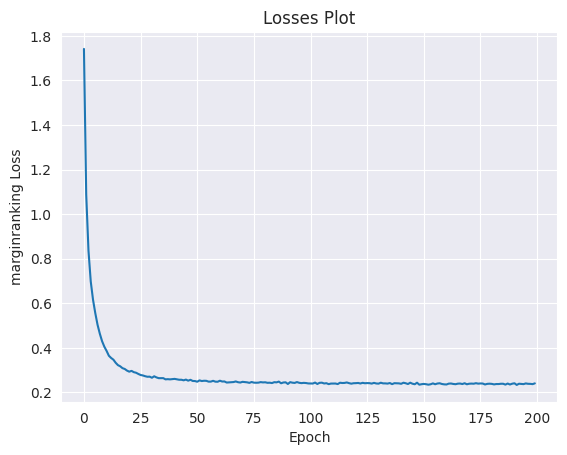

In [ ]:
result.plot_losses()
plt.show()

In [ ]:
node_embeddings = model.entity_representations[0].base[0].vocabulary._embeddings.weight.data
relation_embeddings = model.relation_representations[0].base._embeddings.weight.data

In [ ]:
aggregated_entity_embeddings = []
for entity_id in range(2034):
    embedding = model.entity_representations[0](torch.tensor([entity_id]))
    aggregated_entity_embeddings.append(embedding)

aggregated_entity_embeddings = torch.stack(aggregated_entity_embeddings)
aggregated_entity_embeddings = aggregated_entity_embeddings.squeeze(1)

Here, we are initializing the embedding weights of the GCN model to the node embeddings we generated via the nodepiece model. Thereafter, we train the GCN model for link prediction.

In [ ]:
compgcn_model = CompGCN(
    triples_factory=dataset.training,
    embedding_dim=node_embeddings.shape[1],
)

with torch.no_grad():
    compgcn_model.entity_representations[0].combined.entity_representations._embeddings.weight.data = aggregated_entity_embeddings

optimizer = optim.Adam(compgcn_model.parameters(), lr=0.001)
training_loop = SLCWATrainingLoop(
    model=compgcn_model,
    optimizer=optimizer,
    triples_factory=dataset.training,
    automatic_memory_optimization=False,
)

In [ ]:
training_loop.train(
    triples_factory=dataset.training,
    num_epochs=10,
    batch_size=256,
    use_tqdm=True
)

Training epochs on cpu:  10%|#         | 1/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/256 (0.39%) batches).


Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/256 [00:00<?, ?batch/s]

[1.317524452926591,
 1.3040515419561416,
 0.5436165577266365,
 0.3448193357908167,
 0.2583046852960251,
 0.21659975545480847,
 0.18833887766231783,
 0.1759771614742931,
 0.16085394643596373,
 0.15140839596278965]

We evaluate the model on the test set, initialize the rank-based evaluator and retrieve the MRR and hits@10 results.

In [ ]:
from pykeen.evaluation import RankBasedEvaluator

evaluator = RankBasedEvaluator()
result = evaluator.evaluate(
    model=compgcn_model,
    mapped_triples=dataset.testing.mapped_triples,
    additional_filter_triples=[dataset.training.mapped_triples, dataset.validation.mapped_triples],
    batch_size=256,
)
flat_results = result.to_flat_dict()

Evaluating on cpu:   0%|          | 0.00/1.83k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.41s seconds


In [ ]:
flat_results.get('both.realistic.inverse_arithmetic_mean_rank')

0.008014881052076817

In [ ]:
flat_results.get('both.realistic.hits_at_10')

0.361870897155361

## NodePiece Inductive

In the inductive setting, we are using the InductiveFB15k237 dataset for both Nodepiece and ULTRA model training and evaluation. We use the InductiveNodePieceGNN model which not only tokenizes knowledge graphs but also utilizes a Graph Neural Network (GNN) for effective representation. To optimize the model's parameters, the Adam optimizer is chosen, set with a learning rate of 0.0005. The training process is orchestrated by the SLCWATrainingLoop and the evaluation is a  crucial part of the machine learning pipeline. For this purpose, the SampledRankBasedEvaluator is implemented. This evaluator assesses the model's performance on both  validation and test datasets by ranking them against a set of random  negatives.

In [33]:
from pykeen.datasets.inductive.ilp_teru import InductiveFB15k237
from pykeen.models.inductive import InductiveNodePieceGNN
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation.rank_based_evaluator import SampledRankBasedEvaluator
from pykeen.stoppers import EarlyStopper
from torch.optim import Adam
from pykeen.losses import NSSALoss

In [32]:
dataset = InductiveFB15k237(version="v1", create_inverse_triples=True)

In [34]:
model = InductiveNodePieceGNN(
    triples_factory=dataset.transductive_training,  # training factory, will be also used for a GNN
    inference_factory=dataset.inductive_inference,  # inference factory, will be used for a GNN
    num_tokens=12,  # length of a node hash - how many unique relations per node will be used
    aggregation="mlp",  # aggregation function, defaults to an MLP, can be any PyTorch function
    loss=NSSALoss(margin=15),  # dummy loss
    random_seed=42,
    gnn_encoder=None,  # defaults to a 2-layer CompGCN with DistMult composition function
)

sampling:   0%|          | 0.00/1.59k [00:00<?, ?it/s]

sampling:   0%|          | 0.00/1.09k [00:00<?, ?it/s]

In [36]:
optimizer = Adam(params=model.parameters(), lr=0.0005)

training_loop = SLCWATrainingLoop(
    triples_factory=dataset.transductive_training,  # training triples
    model=model,
    optimizer=optimizer,
    negative_sampler_kwargs=dict(num_negs_per_pos=32),
    mode="training",   # necessary to specify for the inductive mode - training has its own set of nodes
)

valid_evaluator = SampledRankBasedEvaluator(
    mode="validation",   # necessary to specify for the inductive mode - this will use inference nodes
    evaluation_factory=dataset.inductive_validation,  # validation triples to predict
    additional_filter_triples=dataset.inductive_inference.mapped_triples,   # filter out true inference triples
)

test_evaluator = SampledRankBasedEvaluator(
    mode="testing",   # necessary to specify for the inductive mode - this will use inference nodes
    evaluation_factory=dataset.inductive_testing,  # test triples to predict
    additional_filter_triples=dataset.inductive_inference.mapped_triples,   # filter out true inference triples
)

early_stopper = EarlyStopper(
    model=model,
    training_triples_factory=dataset.inductive_inference,
    evaluation_triples_factory=dataset.inductive_validation,
    frequency=1,
    patience=100000,  # for test reasons, turn it off
    result_tracker=None,
    evaluation_batch_size=256,
    evaluator=valid_evaluator,
)

INFO:pykeen.evaluation.rank_based_evaluator:Sampling 50 negatives for each of the 206 evaluation triples.
INFO:pykeen.evaluation.rank_based_evaluator:Sampling 50 negatives for each of the 205 evaluation triples.
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-14b597d8-cfe0-43e7-805b-71d5a900a362.pt


In [ ]:
# Training starts here
training_loop.train(
    triples_factory=dataset.transductive_training,
    stopper=early_stopper,
    num_epochs=100,
)

In [38]:
result = test_evaluator.evaluate(
    model=model,
    mapped_triples=dataset.inductive_testing.mapped_triples,
    additional_filter_triples=dataset.inductive_inference.mapped_triples,
    batch_size=256,
)

Evaluating on cpu:   0%|          | 0.00/205 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds


In [39]:
flat_results = result.to_flat_dict()

In [40]:
flat_results.get('both.realistic.inverse_arithmetic_mean_rank')

0.07986753433942795

In [41]:
flat_results.get('both.realistic.hits_at_10')

0.6048780487804878

## ULTRA Transductive

ULTRA focuses on the invariances across diverse knowledge graphs to enable zero-shot generalization, allowing a single model to adaptively learn and transfer relational structures regardless of the graph's entity and relation vocabularies. While relations in different graphs might vary, their interactions remain consistent. ULTRA captures these interactions through a "graph of relations," where each node represents a distinct relation type from the original graph.

In [1]:
!git clone https://github.com/DeepGraphLearning/ULTRA.git

Cloning into 'ULTRA'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 66 (delta 21), reused 53 (delta 13), pack-reused 0
Receiving objects: 100% (66/66), 4.17 MiB | 3.66 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
!pip install torch==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter==2.1.2 torch-sparse==0.6.18 torch-geometric==2.4.0 -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install ninja easydict pyyaml

In [11]:
import os

os.chdir('ULTRA')

In [26]:
!python script/run.py -c config/transductive/inference.yaml --dataset CoDExSmall --epochs 0 --bpe null --gpus [0] --ckpt ckpts/ultra_4g.pth

/content/ULTRA
DEBUG
/content/ULTRA
ckpts/ultra_4g.pth
18:34:47   Random seed: 1024
18:34:47   Config file: config/transductive/inference.yaml
18:34:47   {'checkpoint': 'ckpts/ultra_4g.pth',
 'dataset': {'class': 'CoDExSmall', 'root': 'ULTRA/kg-datasets/'},
 'model': {'class': 'Ultra',
           'entity_model': {'aggregate_func': 'sum',
                            'class': 'IndNBFNet',
                            'hidden_dims': [64, 64, 64, 64, 64, 64],
                            'input_dim': 64,
                            'layer_norm': True,
                            'message_func': 'distmult',
                            'short_cut': True},
           'relation_model': {'aggregate_func': 'sum',
                              'class': 'NBFNet',
                              'hidden_dims': [64, 64, 64, 64, 64, 64],
                              'input_dim': 64,
                              'layer_norm': True,
                              'message_func': 'distmult',
              

## ULTRA Inductive

In [27]:
!python script/run.py -c config/inductive/inference.yaml --dataset FB15k237Inductive --version v1 --epochs 0 --bpe null --gpus [0] --ckpt ckpts/ultra_4g.pth

/content/ULTRA
DEBUG
/content/ULTRA
ckpts/ultra_4g.pth
18:50:54   Random seed: 1024
18:50:54   Config file: config/inductive/inference.yaml
18:50:54   {'checkpoint': 'ckpts/ultra_4g.pth',
 'dataset': {'class': 'FB15k237Inductive',
             'root': '~/git/ULTRA/kg-datasets/',
             'version': 'v1'},
 'model': {'class': 'Ultra',
           'entity_model': {'aggregate_func': 'sum',
                            'class': 'IndNBFNet',
                            'hidden_dims': [64, 64, 64, 64, 64, 64],
                            'input_dim': 64,
                            'layer_norm': True,
                            'message_func': 'distmult',
                            'short_cut': True},
           'relation_model': {'aggregate_func': 'sum',
                              'class': 'NBFNet',
                              'hidden_dims': [64, 64, 64, 64, 64, 64],
                              'input_dim': 64,
                              'layer_norm': True,
                   